In [1]:
import tensorflow as tf
import numpy as np
from util.utils import *
from model.generator import Generator
from model.discriminator import Discriminator
from model.Layers import *
from model.StyleGan import StyleGAN



c:\Users\Admin\anaconda3\envs\tensorflow_env\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
c:\Users\Admin\anaconda3\envs\tensorflow_env\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.12.0 and strictly below 2.15.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.10.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not fi

Found 21 files belonging to 1 classes.

Model resolution:4x4
STABLE
1000/1000 [==============================] - 69s 61ms/step - d_loss: -14.9085 - g_loss: 9.4372


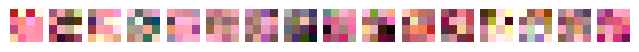


Model resolution:8x8
TRANSITION
1000/1000 [==============================] - 139s 129ms/step - d_loss: -22.9839 - g_loss: 18.7083


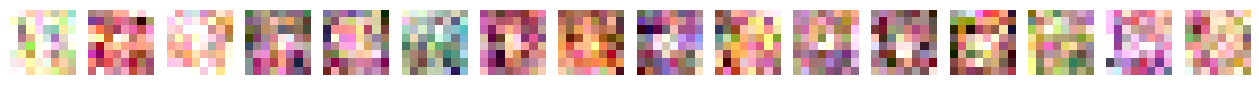

STABLE
1000/1000 [==============================] - 106s 104ms/step - d_loss: -30.9771 - g_loss: 20.2148


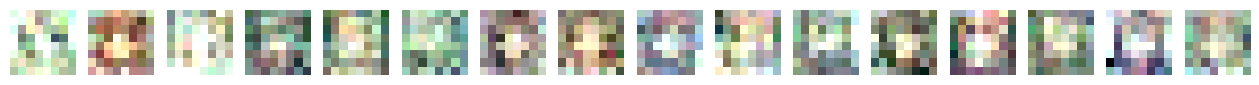


Model resolution:16x16
TRANSITION
1000/1000 [==============================] - 165s 161ms/step - d_loss: -56.3185 - g_loss: 42.5388


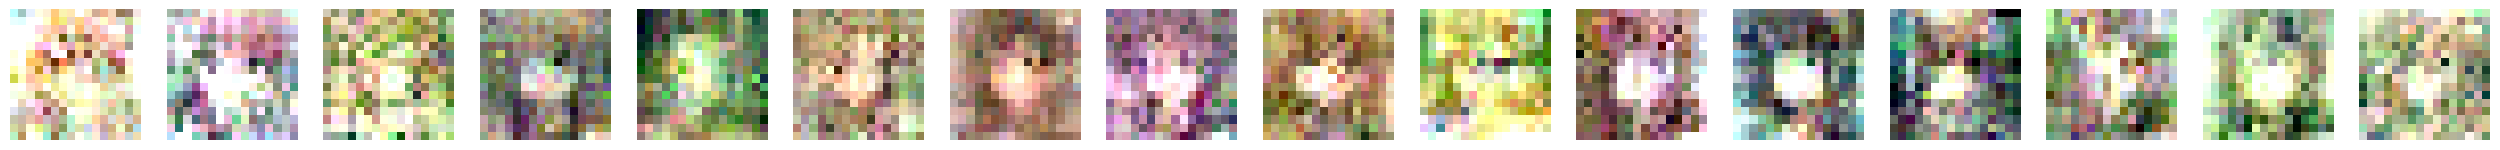

STABLE
1000/1000 [==============================] - 164s 162ms/step - d_loss: -71.3900 - g_loss: 52.9675


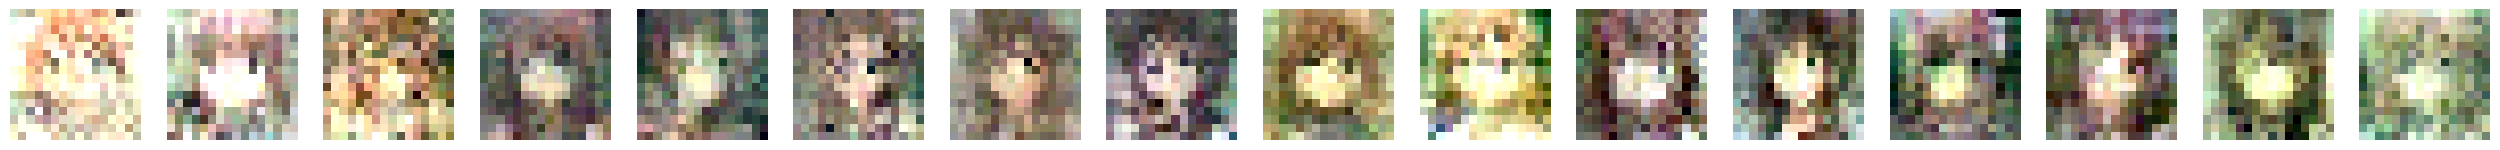


Model resolution:32x32
TRANSITION
 688/1000 [===================>..........] - ETA: 3:14 - d_loss: -137.1584 - g_loss: 112.8767

In [2]:
START_RES = 4
TARGET_RES = 128

style_gan = StyleGAN(start_res=START_RES, target_res=TARGET_RES)

def train(start_res=START_RES, target_res=TARGET_RES, steps_per_epoch=5000, display_images=True):
    opt_cfg = {'learning_rate':1e-3, 'beta_1':0.0, 'beta_2':0.99, 'epsilon':1e-8}

    val_batch_size = 16
    val_z = tf.random.normal((val_batch_size, style_gan.z_dim))  
    val_noise = style_gan.generate_noise(val_batch_size)
    
    start_res_log2 = int(np.log2(start_res))
    target_res_log2 = int(np.log2(target_res))

    for res_log2 in range(start_res_log2, target_res_log2+1):
        res = 2**res_log2
        for phase in ['TRANSITION', 'STABLE']:
            if res==start_res and phase=='TRANSITION':
                continue

            train_dl = create_dataloader(res)

            steps = int(train_step_ratio[res_log2] * steps_per_epoch)

            style_gan.compile(d_optimizer=tf.keras.optimizers.Adam(**opt_cfg),
                              g_optimizer=tf.keras.optimizers.Adam(**opt_cfg), 
                              loss_weights = {'gradient_penalty':10, 'drift':0.001},
                              steps_per_epoch=steps,
                              res=res,
                              phase=phase, run_eagerly=False)

            prefix = f'res_{res}x{res}_{style_gan.phase}'

            ckpt_cb = keras.callbacks.ModelCheckpoint(f'checkpoints/stylegan_{res}x{res}.ckpt', 
                                      save_weights_only=True, verbose=0)
            print(phase)
            style_gan.fit(train_dl, epochs=1, 
                          steps_per_epoch=steps, callbacks=[ckpt_cb])

            if display_images:
                images = style_gan({'z':val_z, 'noise':val_noise, 'alpha':1.0})
                plot_images(images, res_log2)        


def resize_image(resolution, image):
    image = tf.image.resize(
        image, (resolution,resolution), method = tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    image = tf.cast(image, tf.float32)/ 127.5 - 1.0

    return image

def create_dataloader(resolution):
    batch_size = batch_sizes[log2(resolution)]
    data_loader = data_train.map(partial(resize_image ,resolution), num_parallel_calls= tf.data.AUTOTUNE)
    data_loader = data_loader.shuffle(3).batch(batch_size, drop_remainder = True).prefetch(1).repeat()
    return data_loader

batch_sizes = {2:16, 3:16, 4:16, 5:16, 6:16, 7:8, 8:4} # 2**8
train_step_ratio = {k:batch_sizes[2] /v for k,v in batch_sizes.items()}
data_train = keras.utils.image_dataset_from_directory("trainB1/", label_mode = None, image_size=(256,256), batch_size= None)

train(steps_per_epoch=1000)